In [1]:
import jax.numpy as np

from abc import ABC, abstractmethod
from collections.abc import Callable
from jax import Array

from jax.scipy.linalg import expm
from math import comb, factorial

from ode_filters.priors import MaternPrior, IWP
from tqdm import tqdm

import matplotlib.pyplot as plt

import jax.random as jrandom

In [16]:
prior = MaternPrior(2, 1, 10)

In [17]:
prior.Q(0.5)

Array([[0.00082144, 0.00363179, 0.00612379],
       [0.00363179, 0.01779442, 0.03938005],
       [0.00612379, 0.03938006, 0.17951635]], dtype=float32)

In [58]:

q, d = 2, 1
D = d*(q+1)
xi = np.eye(d) * 12.5
#prior = IWP(q, d, Xi=xi)
prior = MaternPrior(q, d, 10.1, Xi=xi)
ts, h = np.linspace(0, 10, 222, retstep=True)
mu_0 = np.zeros(D)
Sigma_0 = np.eye(D)*1e-12

# Initialize RNG key
key = jrandom.PRNGKey(0)

# Number of trajectory samples
k = 5

# Storage for all trajectories
trajectories = []

# Repeat sampling k times
for _ in range(k):
    # Split key for this repetition
    key, subkey = jrandom.split(key)
    x_0 = jrandom.multivariate_normal(subkey, mean=mu_0, cov=Sigma_0)
    x_s = [x_0]
    A_h, Q_h = prior.A(h), prior.Q(h)
    
    # Simulate trajectory
    for _ in ts:
        key, subkey = jrandom.split(key)
        mu_nxt = A_h @ x_s[-1]
        x_nxt = jrandom.multivariate_normal(subkey, mean=mu_nxt, cov=Q_h)
        x_s.append(x_nxt)
    
    trajectories.append(np.array(x_s))

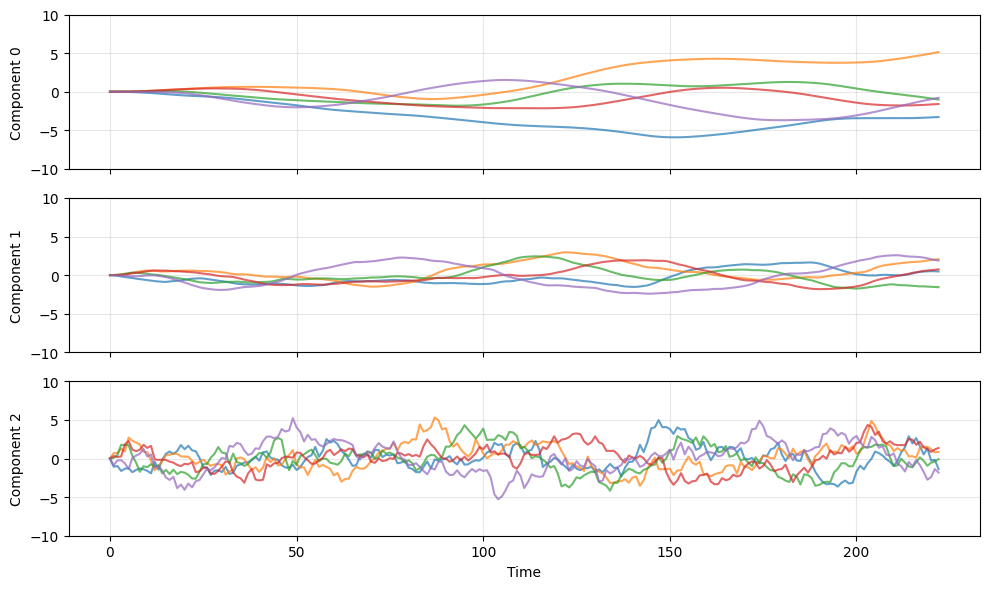

In [59]:
# Convert to array for easier manipulation
trajectories = np.array(trajectories)  # Shape: (k, len(ts)+1, D)

# Plot all trajectories in D subplots (one per state component)
fig, axes = plt.subplots(D, 1, figsize=(10, 2*D), sharex=True)

for traj in trajectories:
    for i in range(D):
        axes[i].plot(traj[0:, i], alpha=0.7)

for i in range(D):
    axes[i].set_ylabel(f'Component {i}')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([-10,10])

axes[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

In [45]:
x_s = np.array(x_s)
x_s.shape

(1001, 2)